### Load libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
from keras.layers import Flatten, Convolution2D as Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import MaxPooling2D, AveragePooling2D, BatchNormalization as BatchNorm
import h5py
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

Using TensorFlow backend.


### Read data

In [2]:
path = os.getcwd()
temp = path.split('/')
temp.pop(-1)
path = '/'.join(temp)

with h5py.File(path + '/data/train_16frames.h5', 'r') as h5file:
    X_train = h5file['train'][:]
    Y_train = h5file['target'][:]
    h5file.close()

# shuffle both
X_train, Y_train = shuffle(X_train, Y_train)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]))
    
X_train.shape, Y_train.shape

((3596, 1, 16, 13), (3596, 4))

### Split to train and test sets

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=15)

### Build a CNN classifier

In [19]:
nb_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)
batch_size = 16
nb_epochs = 40
nb_classes = Y_train.shape[1]
input_shape = (1, X_train.shape[2], X_train.shape[3])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, verbose=1)

model = Sequential()
model.add(Conv2D(nb_filters, kernel_size=kernel_size,
                    border_mode='valid', input_shape=input_shape, data_format='channels_first'))
model.add(BatchNorm())
model.add(LeakyReLU(alpha=0.01))

model.add(Conv2D(nb_filters, kernel_size=kernel_size, data_format='channels_first'))
model.add(BatchNorm())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=pool_size, strides=(1, 1)))
model.add(Dropout(0.1))

model.add(Conv2D(nb_filters, kernel_size=kernel_size, data_format='channels_first'))
model.add(BatchNorm())
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=pool_size, strides=(1, 1)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('linear'))
model.add(Dropout(0.1))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

model.summary()
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs, verbose=1, callbacks=[early_stopping],
                    validation_split=0.15)

/lyceum/ao2u17/.conda/envs/keras_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_size=(3, 3), input_shape=(1, 16, 13..., data_format="channels_first", padding="valid")`
  if sys.path[0] == '':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 14, 11)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 14, 11)        44        
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 14, 11)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 12, 9)         9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 12, 9)         36        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 12, 9)         0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 11, 9)         0         
__________

### Evaluate the model performance

In [20]:
Y_pred = model.predict_proba(X_test)

ref = np.zeros(shape=(Y_test.shape[0], Y_test.shape[1]))
i = 0
for idx in Y_pred.argmax(axis=-1):
    ref[i, idx] = 1 
    i += 1
    
print('Accuracy is', accuracy_score(Y_test, ref))
AUC = roc_auc_score(Y_test, Y_pred)
print('AUC is', AUC)

Accuracy is 0.475
AUC is 0.7148167251569506


In [21]:
Y_test

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]], dtype=uint8)

In [22]:
Y_pred

array([[0.30056596, 0.29500943, 0.30975953, 0.09466504],
       [0.05555949, 0.4608614 , 0.38218164, 0.10139746],
       [0.17022268, 0.39493033, 0.317681  , 0.11716594],
       ...,
       [0.16353147, 0.40110224, 0.30941814, 0.12594818],
       [0.19921398, 0.32617363, 0.29947972, 0.17513265],
       [0.34092033, 0.30625427, 0.26076186, 0.09206348]], dtype=float32)

### Visualize training

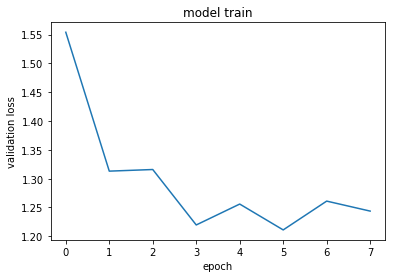

In [23]:
plt.plot(history.history['val_loss'])
plt.title('model train')
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.show()

### Save model weights

In [24]:
model.save(path + '/data/model_CNN.h5')